# Binary metric A/B test design example

This example is about how *Ambrosia* can be used to calculate the parameters of an experiment with binary metrics.
For a binary metric, there are some differences in the calculations regarding continuous metrics.

Let's consider an example of calculating the parameters of a hypothetical experiment based on synthetic data on user retention rate.

In [1]:
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [31]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ambrosia.designer import Designer, design_binary

Load data

In [4]:
data = pd.read_csv('../tests/test_data/ltv_retention.csv')

In [5]:
data.head()

,LTV,retention
0,38.004891,0.0
1,70.588069,1.0
2,13.585602,1.0
3,19.813550,0.0
4,207.213003,0.0


## Experiment design based on available historical data

In many situations, we have historical retention/conversion rate data available, and this data can be used in the same way as continuous data.

In order to calculate some A/B test parameters of interest, such as experimental power, group size, or minimum detectable effect, we need to pass them in the same way to the ``Designer`` class.

In [16]:
designer = Designer(dataframe=data, metrics='retention')

For binary data, we can use either the ``"theory"`` method or the ``"binary"`` method.

The ``"theory"`` method performs a numerical calculation of the parameters using various approximations. \
The approximation method choice is controlled by the ``stabilizing_method`` parameter and defaults to ``"asin"`` which is more accurate and robust. You can find more information about the approximations on the Net.

The ``"binary"`` approach does parameter estimation based on the multiple construction of chosen confidence interval. Some of these intervals are quite exotic and should be studied for conscious application. As a default a standard Wald interval is used. \
This approach is more slowly and it's accuracy depends on the number of iterations.

Now let's create a grid of known parameters and calculate interested ones. We will use two above methods consequntly.

In [20]:
# Create grid of MDEs and group sizes
# I and II type errros will have default values
effects = [1.02, 1.05, 1.1]
group_sizes = [500, 1000, 2000]

First design group sizes

In [76]:
designer.run(to_design='size', method='theory', effects=effects)

errors,(0.05; 0.2)
effects,
2.0%,58885
5.0%,9464
10.0%,2382


Then design MDE values 

In [23]:
designer.run(to_design='effect', method='theory', sizes=group_sizes)

errors,(0.05; 0.2)
sample_sizes,
500,21.9%
1000,15.5%
2000,10.9%


Finally design power

In [24]:
designer.run(to_design='power', method='theory', effects=effects, sizes=group_sizes)

sample sizes              500    1000   2000
First type error Effect                     
0.05             2.0%     5.8%   6.5%   8.1%
                 5.0%     9.9%  14.9%  25.1%
                 10.0%   25.0%  44.3%  72.8%

Now let's design groups size for 10% MDE value again, using ``"binary"`` approach and compare to ``"theory"`` method result. \
We will increase number of constructed intervals using ``amount`` parameter to check how the accuracy of estimated group size value is increased

In [73]:
interval_amounts = [2000, 5000, 20000]
group_size_estimation_dict = {}

In [74]:
for amount in interval_amounts:
    group_size_estimation_dict[amount] = []
    for step in range(200):
        estimated_size = designer.run(to_design='size', 
                                      method='binary', 
                                      interval_type='wald', 
                                      amount=amount, 
                                      effects=1.1).values[0][0]
        group_size_estimation_dict[amount].append(estimated_size)

Draw the results

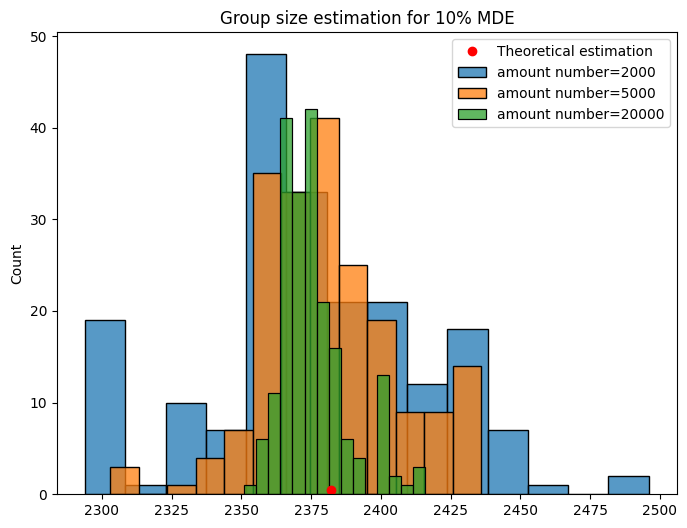

In [75]:
plt.figure(figsize=(8,6))
plt.title('Group size estimation for 10% MDE')
for key in group_size_estimation_dict:
    label = f'amount number={key}'
    sns.histplot(group_size_estimation_dict[key], label=label)
plt.plot(2382, 0.5, 'ro', label='Theoretical estimation')
plt.legend();

For small numbers of iterations interval parameter estimation is quite noisy, and one should be aware of it.

## Experiment design based on a known retention rate value

In some cases, complete data on a binary metric is missing or not needed. \
These can be known and pre-calculated conversion/retention values, or simply the absence of any historical data (in which case, for example, assumption for rates are needed).

And now we will calculate the experimental parameters using the known retantion rate value of 0.1.

In [80]:
retention = 0.1

In [81]:
# Create grid of MDEs and group sizes
# I and II type errros will have default values
effects = [1.01, 1.03, 1.05]
group_sizes = [20_000, 50_000, 100_000]

Design group sizes

In [82]:
design_binary(to_design='size', prob_a=retention, method='theory', effects=effects)

errors,(0.05; 0.2)
effects,
1.0%,1419062
3.0%,159059
5.0%,57756


Design MDE values 

In [85]:
design_binary(to_design='effect', prob_a=retention, method='theory', sizes=group_sizes)

errors,(0.05; 0.2)
sample_sizes,
20000,8.6%
50000,5.4%
100000,3.8%


Design test power

In [86]:
design_binary(to_design='power', prob_a=retention, method='theory', effects=effects, sizes=group_sizes)

sample sizes            20000  50000  100000
First type error Effect                     
0.05             1.0%     6.3%   8.2%  11.5%
                 3.0%    16.8%  34.9%  60.3%
                 5.0%    37.8%  74.1%  95.8%

---

You can learn more information about how you can do A/B test design using *Ambrosia*

Check:
- Main example of experiments design using `Designer` class